In [1]:
#!pip install geneticalgorithm

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
import shap
from keras import models
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt

## Rough Set Flow Graph

In [2]:
graph_file_name = 'rsfg.csv'

In [3]:
def save_edge_list_with_coefficients_csv(df, filename):
    num_cols = df.shape[1]
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Level", "Relation", "Cnt (count)", "Cer (certainty)", "Cov (coverage)", "Str (strength)"])
        for level in range(num_cols - 1):
            edge_counts = {}
            source_counts = {}
            target_counts = {}
            #lower_dict = {}
            #upper_dict = {}
            total_possible = len(df.iloc[:, level + 1])
            for _, row in df.iterrows():
                source = str(row.iloc[level])
                target = str(row.iloc[level + 1])
                key = (source, target)
                edge_counts[key] = edge_counts.get(key, 0) + 1
                source_counts[source] = source_counts.get(source, 0) + 1
                target_counts[target] = target_counts.get(target, 0) + 1
                #lower_dict.setdefault(source, set()).add(target)
                #upper_dict.setdefault(target, set()).add(source)
            for (source, target), count in edge_counts.items():
                #cer = 1 / len(lower_dict[source]) if lower_dict[source] else 0
                #cov = 1 / len(upper_dict[target]) if upper_dict[target] else 0
                cer = count / source_counts[source] if source_counts[source] else 0
                cov = count / target_counts[target] if target_counts[target] else 0
                str_value = count / total_possible if total_possible else 0
                lev = f"{level}<>{level+1}"
                rel = f"{source}-->{target}"
                writer.writerow([lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"])

## Data

In [4]:
(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

#print(x_train)

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(48000, 10)
(12000, 28, 28, 1)
(12000, 10)
(10000, 28, 28, 1)
(10000, 10)


## Model

In [6]:
n_filters_conv_1 = 4
n_filters_conv_2 = 4
n_neurons_dense_1 = 50
n_neurons_dense_2 = 10

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(n_filters_conv_1, (5, 5), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(layers.Conv2D(n_filters_conv_2, (5, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_neurons_dense_1, activation='relu'))
model.add(layers.Dense(n_neurons_dense_2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 4)      │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        80,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,068 (316.67 KB)

 Trainable params: 81,068 (316.67 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_valid, y_valid), verbose=0)

I0000 00:00:1742067946.857931 1354188 service.cc:148] XLA service 0x732e9c003660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742067946.857957 1354188 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-15 20:45:46.891353: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742067946.948880 1354188 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742067947.712685 1354188 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [10]:
layer_outputs = [layer.output for layer in model.layers[:5]]
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

In [11]:
activations = activation_model.predict(x=x_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 864us/step


In [12]:
artifact_clusters = pd.DataFrame()

In [13]:
for f in range(n_filters_conv_1):

    print('filter: '+str(f))

    activations_f = activations[0][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=4).fit(activations_f)

    artifact_clusters['l0_f'+str(f)] = ac_f.labels_

filter: 0
filter: 1
filter: 2
filter: 3


In [14]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3
0          0      0      2      1
1          0      0      1      1
2          3      2      2      0
3          0      0      2      2
4          0      0      0      2
...      ...    ...    ...    ...
47995      0      0      0      2
47996      0      0      3      1
47997      1      1      2      0
47998      0      0      1      1
47999      0      0      3      1

[48000 rows x 4 columns]


In [16]:
for f in range(n_filters_conv_2):

    print('filter: '+str(f))

    activations_f = activations[1][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=4).fit(activations_f) 

    artifact_clusters['l1_f'+str(f)] = ac_f.labels_

filter: 0
filter: 1
filter: 2
filter: 3


In [17]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3
0          0      0      2      1      1      3      0      1
1          0      0      1      1      3      3      0      0
2          3      2      2      0      0      1      0      1
3          0      0      2      2      0      0      3      1
4          0      0      0      2      1      3      0      2
...      ...    ...    ...    ...    ...    ...    ...    ...
47995      0      0      0      2      0      0      3      0
47996      0      0      3      1      2      3      0      0
47997      1      1      2      0      0      2      2      3
47998      0      0      1      1      1      3      0      1
47999      0      0      3      1      1      3      0      1

[48000 rows x 8 columns]


In [18]:
activations_d_1 = activations[3]
ac_d = AgglomerativeClustering(n_clusters=10).fit(activations_d_1)
artifact_clusters['l3'] = ac_d.labels_

In [19]:
print(ac_d.labels_)

[8 7 2 ... 6 8 8]


In [20]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3
0          0      0      2      1      1      3      0      1   8
1          0      0      1      1      3      3      0      0   7
2          3      2      2      0      0      1      0      1   2
3          0      0      2      2      0      0      3      1   4
4          0      0      0      2      1      3      0      2   0
...      ...    ...    ...    ...    ...    ...    ...    ...  ..
47995      0      0      0      2      0      0      3      0   4
47996      0      0      3      1      2      3      0      0   7
47997      1      1      2      0      0      2      2      3   6
47998      0      0      1      1      1      3      0      1   8
47999      0      0      3      1      1      3      0      1   8

[48000 rows x 9 columns]


In [21]:
predictions = model.predict(x=x_train)
pred = np.argmax(predictions, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step


In [22]:
print(pred)

[8 3 1 ... 7 8 8]


In [23]:
artifact_clusters['p'] = pred

In [24]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
0          0      0      2      1      1      3      0      1   8  8
1          0      0      1      1      3      3      0      0   7  3
2          3      2      2      0      0      1      0      1   2  1
3          0      0      2      2      0      0      3      1   4  6
4          0      0      0      2      1      3      0      2   0  2
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47995      0      0      0      2      0      0      3      0   4  6
47996      0      0      3      1      2      3      0      0   7  9
47997      1      1      2      0      0      2      2      3   6  7
47998      0      0      1      1      1      3      0      1   8  8
47999      0      0      3      1      1      3      0      1   8  8

[48000 rows x 10 columns]


In [25]:
artifact_clusters.to_csv('isog.csv', sep=',', index=False)

In [26]:
isog = pd.DataFrame()

In [27]:
isog['conv1'] = artifact_clusters.astype(str).loc[:,['l0_f0', 'l0_f1', 'l0_f2', 'l0_f3']].apply('_'.join, axis=1)

In [28]:
isog['conv2'] = artifact_clusters.astype(str).loc[:,['l1_f0', 'l1_f1', 'l1_f2', 'l1_f3']].apply('_'.join, axis=1)

In [29]:
isog['dense1'] = artifact_clusters['l3']

In [30]:
isog['output'] = artifact_clusters['p']

In [31]:
print(isog)

         conv1    conv2  dense1  output
0      0_0_2_1  1_3_0_1       8       8
1      0_0_1_1  3_3_0_0       7       3
2      3_2_2_0  0_1_0_1       2       1
3      0_0_2_2  0_0_3_1       4       6
4      0_0_0_2  1_3_0_2       0       2
...        ...      ...     ...     ...
47995  0_0_0_2  0_0_3_0       4       6
47996  0_0_3_1  2_3_0_0       7       9
47997  1_1_2_0  0_2_2_3       6       7
47998  0_0_1_1  1_3_0_1       8       8
47999  0_0_3_1  1_3_0_1       8       8

[48000 rows x 4 columns]


In [32]:
isog.to_csv('isog.csv', sep=' ', index=False)

In [33]:
save_edge_list_with_coefficients_csv(isog, graph_file_name)

In [34]:
rsfg = pd.read_csv(graph_file_name, sep=',')

In [35]:
print(rsfg)

     Level           Relation  Cnt (count)  Cer (certainty)  Cov (coverage)  \
0     0<>1  0_0_2_1-->1_3_0_1          231         0.350000        0.080404   
1     0<>1  0_0_1_1-->3_3_0_0          735         0.146765        0.270818   
2     0<>1  3_2_2_0-->0_1_0_1         4296         0.848509        0.966914   
3     0<>1  0_0_2_2-->0_0_3_1           25         0.213675        0.250000   
4     0<>1  0_0_0_2-->1_3_0_2          552         0.083712        0.750000   
...    ...                ...          ...              ...             ...   
2949  2<>3              8-->4            1         0.000216        0.000216   
2950  2<>3              1-->8            2         0.000423        0.000427   
2951  2<>3              1-->1            1         0.000211        0.000185   
2952  2<>3              2-->5            2         0.000380        0.000461   
2953  2<>3              9-->0            1         0.000246        0.000211   

      Str (strength)  
0           0.004812  
1    

In [36]:
rsfg['Con (confidence)'] = 2*rsfg['Cer (certainty)']*rsfg['Cov (coverage)']/(rsfg['Cer (certainty)']+rsfg['Cov (coverage)'])

In [37]:
print(rsfg)

     Level           Relation  Cnt (count)  Cer (certainty)  Cov (coverage)  \
0     0<>1  0_0_2_1-->1_3_0_1          231         0.350000        0.080404   
1     0<>1  0_0_1_1-->3_3_0_0          735         0.146765        0.270818   
2     0<>1  3_2_2_0-->0_1_0_1         4296         0.848509        0.966914   
3     0<>1  0_0_2_2-->0_0_3_1           25         0.213675        0.250000   
4     0<>1  0_0_0_2-->1_3_0_2          552         0.083712        0.750000   
...    ...                ...          ...              ...             ...   
2949  2<>3              8-->4            1         0.000216        0.000216   
2950  2<>3              1-->8            2         0.000423        0.000427   
2951  2<>3              1-->1            1         0.000211        0.000185   
2952  2<>3              2-->5            2         0.000380        0.000461   
2953  2<>3              9-->0            1         0.000246        0.000211   

      Str (strength)  Con (confidence)  
0         

In [38]:
levels = rsfg['Level'].unique()
print(levels)

['0<>1' '1<>2' '2<>3']


In [ ]:
rsfg_layers = list()
node_dicts = list()

for level in levels:

    layer = rsfg.loc[rsfg['Level']==level,:]
    layer[['Source', 'Target']] = layer['Relation'].str.split('-->', expand=True)

    if len(node_dicts)==0:
        
        node_dict_1 = {key: i for i, key in enumerate(layer['Source'].unique())}
        node_dicts.append(node_dict_1)

        layer['Source_id'] = layer['Source'].map(node_dict_1)

    else:

        layer['Source_id'] = layer['Source'].map(node_dicts[-1])        

    node_dict_2 = {key: i for i, key in enumerate(layer['Target'].unique())}
    node_dicts.append(node_dict_2)

    layer['Target_id'] = layer['Target'].map(node_dict_2)
    
    layer = layer[['Source_id', 'Target_id', 'Source', 'Target', 'Con (confidence)']]
        
    rsfg_layers.append(layer)

## Genetic Algorithm

https://pypi.org/project/geneticalgorithm/

In [41]:
def fitness(x):

    confidences = list()

    for i in range(len(x)-1):

        layer = rsfg_layers[i]

        confidence = layer.loc[(layer['Source_id']==x[i]) & (layer['Target_id']==x[i+1]), ['Con (confidence)']]

        if len(confidence)==0:

            return 0
            
        confidences.append(confidence['Con (confidence)'])

    return -np.min(np.array(confidences))  

[[0, 171], [0, 187], [0, 9], [0, 9]]
 The best solution found:                                                                           
 [ 7. 13.  3.  3.]

 Objective function:
 -0.49865025752168657


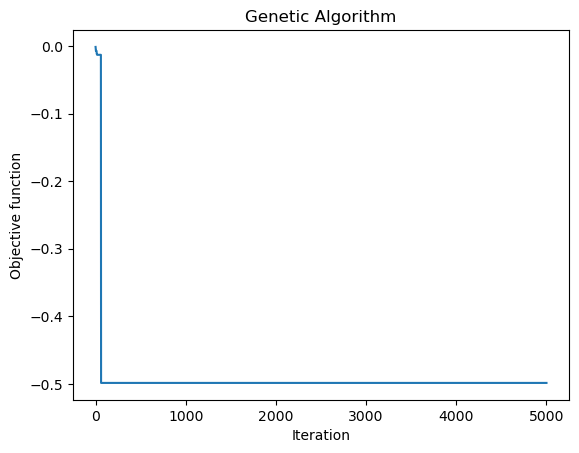

In [42]:
parameters = {'max_num_iteration': 5000,
              'population_size': 20,
              'parents_portion': 0.3,
              'mutation_probability':0.1,
              'crossover_probability': 0.1,
              'elit_ratio': 0.01,
              'crossover_type':'uniform',
              'max_iteration_without_improv': None}


varbounds = []

for d in node_dicts:

    varbounds.append([0,len(d)-1])

print(varbounds)

gen_alg = ga(function=fitness, dimension=len(varbounds), variable_type='int', variable_boundaries=np.array(varbounds), algorithm_parameters=parameters)

gen_alg.run()

In [43]:
best_path = gen_alg.output_dict['variable']

In [44]:
best_path_info = list()

for i in range(len(best_path)-1):

        layer = rsfg_layers[i]

        path_info = layer.loc[(layer['Source_id']==best_path[i]) & (layer['Target_id']==best_path[i+1]), ['Con (confidence)', 'Source', 'Target']]

        best_path_info.append(path_info)

print(best_path_info)

[    Con (confidence)   Source   Target
59           0.49865  2_3_0_2  0_0_1_2,       Con (confidence)   Source Target
2138          0.545946  0_0_1_2      4,       Con (confidence) Source Target
2872          0.986072      4      6]


## Visualization

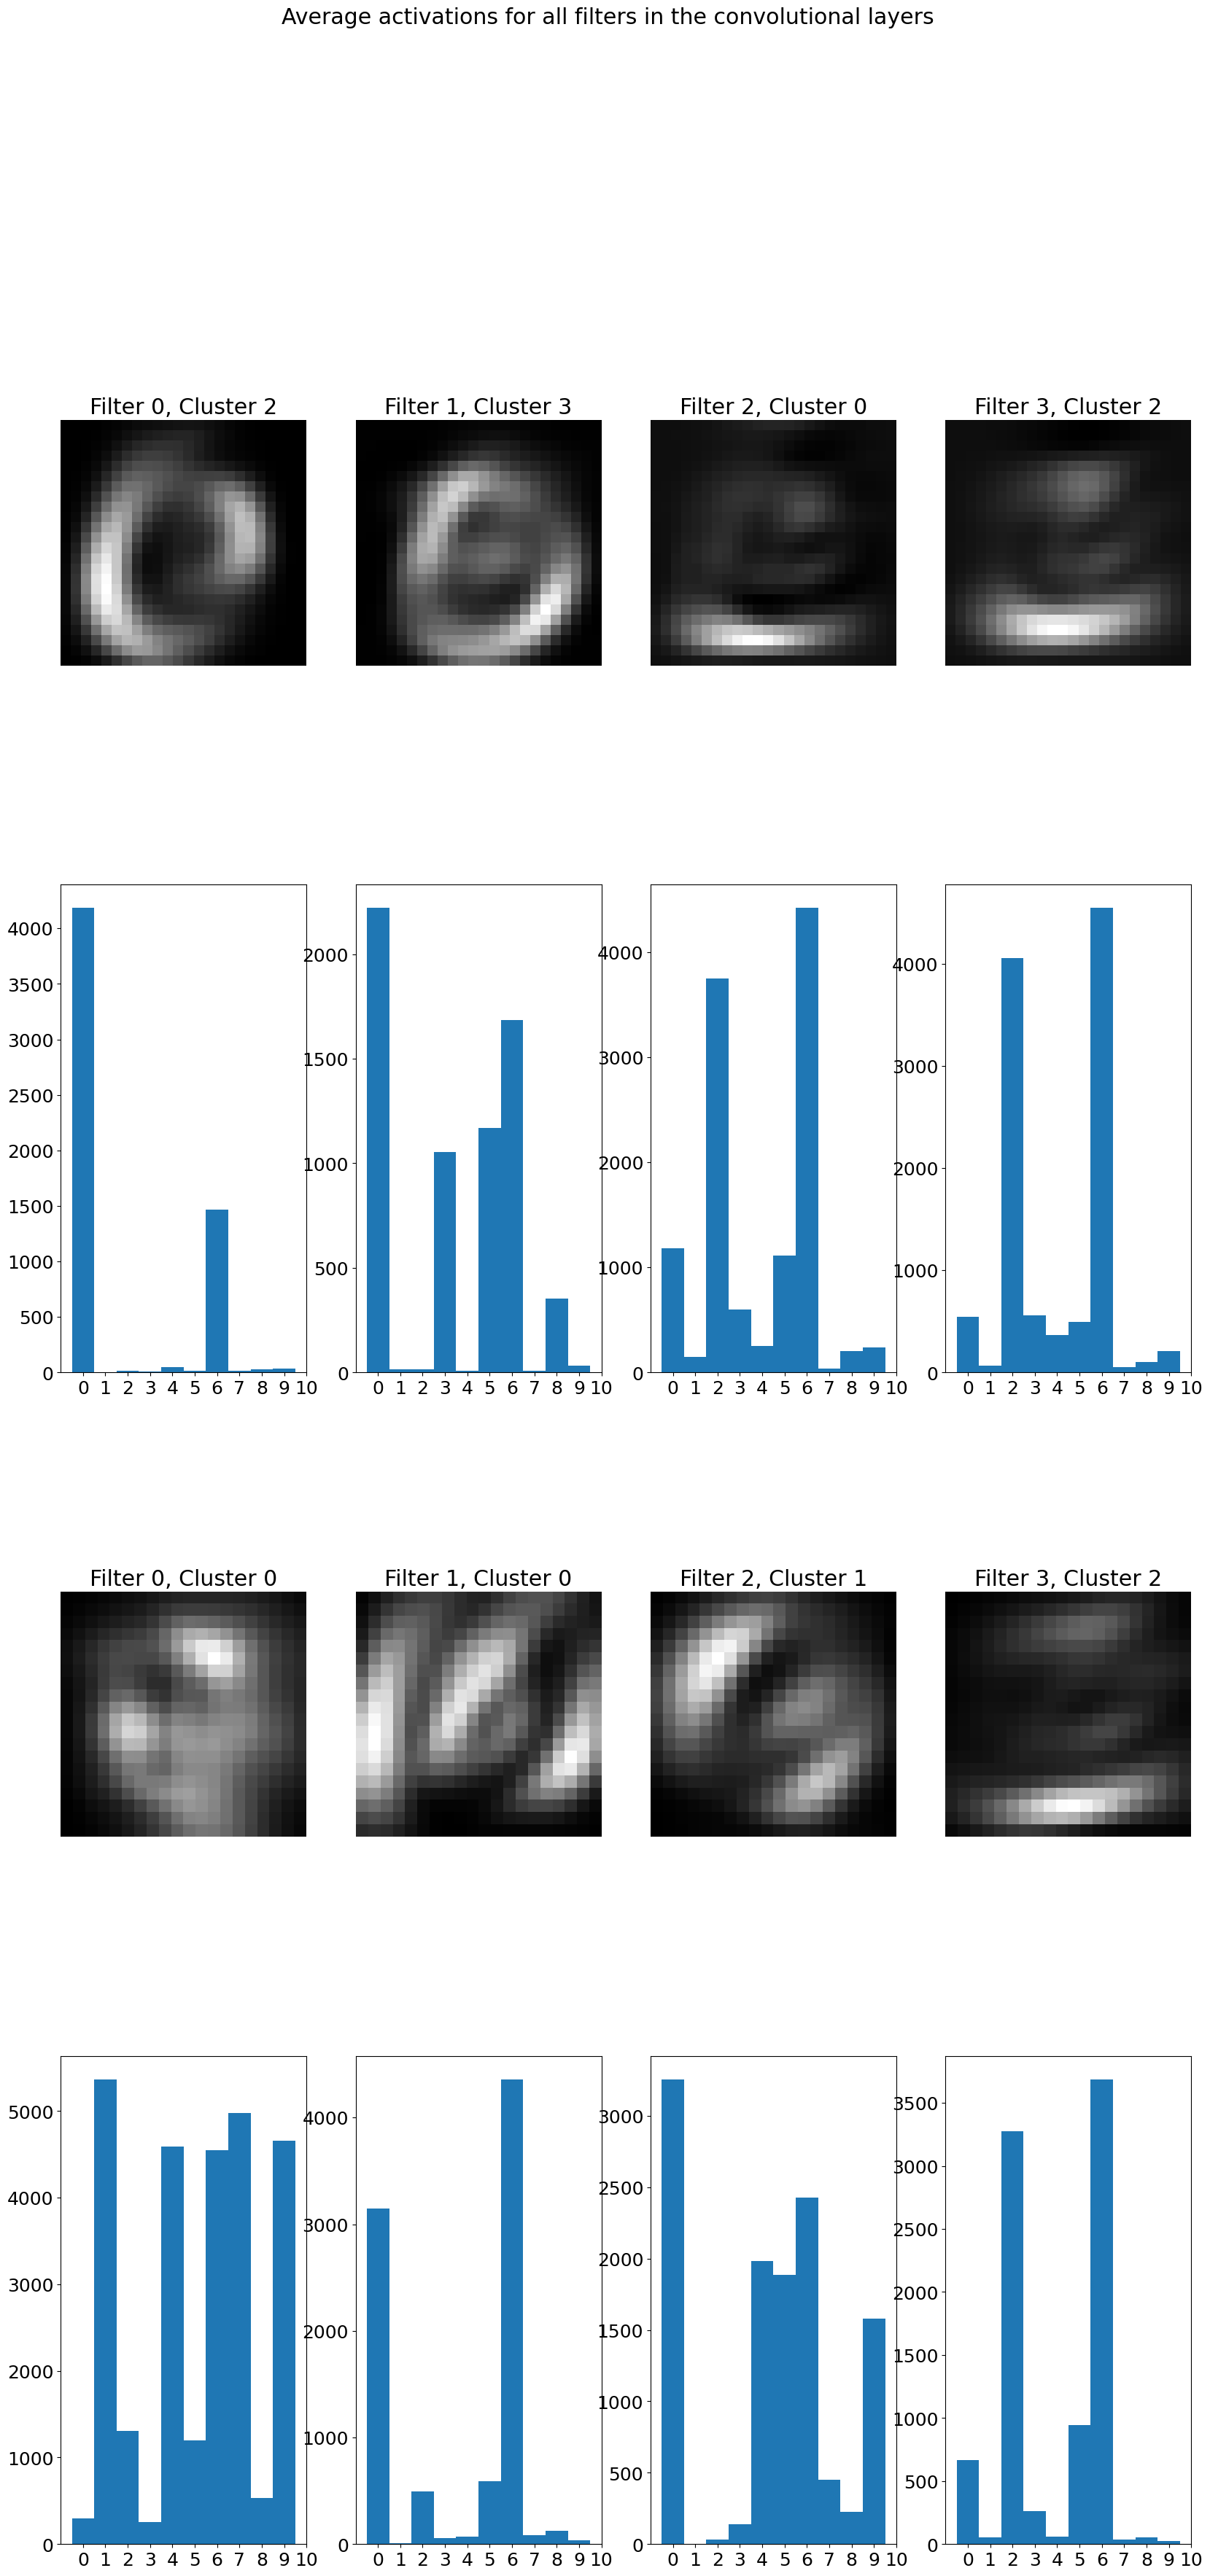

In [45]:
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(4, 4, figsize=(20, 40)) 
fig.suptitle("Average activations for all filters in the convolutional layers")

source_cluster_indexes = best_path_info[0]['Source'].item().split('_')
target_cluster_indexes = best_path_info[0]['Target'].item().split('_')

row = 0

for filter_index in range(4):

    source_cluster_index = int(source_cluster_indexes[filter_index])
    target_cluster_index = int(target_cluster_indexes[filter_index])
    
    activation_data_0 = activations[0][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :, :, filter_index]
    cluster_0 = artifact_clusters.loc[artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]

    activation_data_1 = activations[1][artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :, :, filter_index]
    cluster_1= artifact_clusters.loc[artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :]

    average_activation_0 = np.mean(activation_data_0, axis=0)
    average_activation_1 = np.mean(activation_data_1, axis=0)

    col = filter_index
            
    axes[2*row, col].imshow(average_activation_0, cmap=plt.get_cmap('gray'))
    axes[2*row, col].axis("off")
    axes[2*row, col].set_title(f"Filter {filter_index}, Cluster {source_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+1, col].hist(cluster_0['p'], bins)
    axes[2*row+1, col].set_xticks(bins + 0.5)

    axes[2*row+2, col].imshow(average_activation_1, cmap=plt.get_cmap('gray'))
    axes[2*row+2, col].axis("off")
    axes[2*row+2, col].set_title(f"Filter {filter_index}, Cluster {target_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+3, col].hist(cluster_1['p'], bins)
    axes[2*row+3, col].set_xticks(bins + 0.5)

# Zapisanie wykresu do pliku PNG
plt.savefig("activation_all_filters_conv_1.png")
plt.show()
plt.close(fig)  # Zamknięcie figury po zapisie

## Shap

/srv/anaconda3/envs/kp_3_11_10/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(2, 28, 28, 1))']
  warnings.warn(msg)


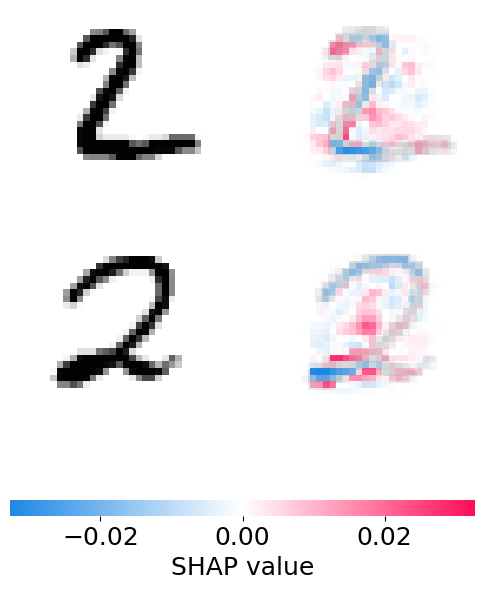

In [59]:
y_2 = y_test[:,2]
y_2_idx = [i for i in range(len(y_2)) if y_2[i] == 1]

#print(y_2_idx)

x_2 = x_test[y_2_idx]

background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(x_2[0:2])
shap.image_plot(shap_values, -x_2[0:2])